In [2]:
import re
import numpy as np
import polars as pl
import yaml
import matplotlib.pyplot as plt

from scipy.stats import t

# Use the same HV implementation in moocore
import moocore

In [275]:
data_path = "./results/data/g9_ranking_gen150_runs500_ctmed_psize12.parquet"
front_path = "./results/fronts/g9_gen10000_psize200.parquet"
thresholds_path = "./results/thresholds/g9.yaml"

objective_symbol = "f_1"
constraint_symbols = ["c_1", "c_2", "c_3", "c_4"]
ct_level = "med"  # "low" | "med" | "high"

f_col = f"{objective_symbol}_min"
c_cols = constraint_symbols
dim_cols = [f_col] + c_cols

In [276]:
df = pl.read_parquet(data_path)
df_front = pl.read_parquet(front_path)

df.select(["run", "generation"] + dim_cols).head()

run,generation,f_1_min,c_1,c_2,c_3,c_4
i32,i32,f64,f64,f64,f64,f64
0,1,131043.39843,10164.740879,-141.85134,-24.429622,142.730645
0,1,983973.381178,593.375349,224.087185,-365.263759,268.597931
0,1,678082.806612,115.040095,-235.668971,20.045218,6.403835
0,1,18311.177082,223.431097,-162.409546,-173.867563,-55.496872
0,1,7509.683237,2729.572496,-228.141808,23.179897,147.764367


In [277]:
with open(thresholds_path, encoding="utf-8") as f:
    thresholds_doc = yaml.safe_load(f)

level_constraints = dict(thresholds_doc["levels"].get(ct_level, {}))
constraints = {c: float(level_constraints.get(c, 0.0)) for c in c_cols}

df_front.describe()

statistic,x_1,x_2,x_3,x_4,x_5,x_6,x_7,f_1,c_1,c_2,c_3,c_4,f_1_min,c_1_min,c_2_min,c_3_min,c_4_min,generation
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",525733.0,525733.0,525733.0,525733.0,525733.0,525733.0,525733.0,525733.0,525733.0,525733.0,525733.0,525733.0,525733.0,525733.0,525733.0,525733.0,525733.0,525733.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",-7.375097,-5.813443,-0.007611,-9.510179,6.546127,-4.951198,9.9003,3.0004e6,7981.786566,-366.736369,-178.127354,14.627485,3.0004e6,7981.786566,-366.736369,-178.127354,14.627485,5058.582522
"""std""",2.426088,2.519009,0.196307,1.117253,2.811942,3.639476,0.355099,3.4131e6,9202.462079,23.391824,233.138381,97.757413,3.4131e6,9202.462079,23.391824,233.138381,97.757413,2867.924331
"""min""",-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-9.199139,346.212623,-165.02767,-401.99946,-505.999859,-159.907839,346.212623,-165.02767,-401.99946,-505.999859,-159.907839,1.0
"""25%""",-9.776171,-7.827484,-0.081694,-9.986513,4.41379,-8.337348,9.957544,87374.639414,894.804795,-383.150329,-380.757443,-75.213047,87374.639414,894.804795,-383.150329,-380.757443,-75.213047,2600.0
"""50%""",-7.979853,-6.006278,-0.01058,-9.908558,7.628317,-5.189933,9.992559,1.9839e6,4297.814803,-370.667538,-232.962654,12.428795,1.9839e6,4297.814803,-370.667538,-232.962654,12.428795,5007.0
"""75%""",-5.404047,-3.600077,0.069066,-9.536023,8.901865,-0.848762,9.999521,4.9901e6,11680.363021,-352.889609,25.364099,92.746885,4.9901e6,11680.363021,-352.889609,25.364099,92.746885,7558.0
"""max""",5.428355,6.904074,5.547074,10.0,10.0,10.0,10.0,1.0015e7,30523.133159,699.798542,410.510961,492.419433,1.0015e7,30523.133159,699.798542,410.510961,492.419433,10000.0


In [278]:
# %% [code] Cell 5
import numpy as np

eps_percent = 0.01  # padding as fraction of local (selected-row) ranges


def threshold(ci: str) -> float:
    """Threshold for relaxed constraint ci. If missing, treat as 0 (i.e., no relaxation)."""
    return float(constraints.get(ci, 0.0))


def filter_relax_only(relaxed: str | None) -> pl.Expr:
    """
    Build filter where:
      - if relaxed is None: all constraints enforced as c <= 0
      - if relaxed is ci: ci is allowed up to tau_i, all other constraints enforced as <= 0
    """
    terms = []
    for c in c_cols:
        if relaxed is None:
            terms.append(pl.col(c) <= 0.0)
        else:
            if c == relaxed:
                terms.append(pl.col(c) <= threshold(c))
            else:
                terms.append(pl.col(c) <= 0.0)
    return pl.all_horizontal(terms)


selected = []

# A) Best objective with ALL constraints enforced (c <= 0) -> defines objective component
cand = df_front.filter(filter_relax_only(relaxed=None))
if cand.height == 0:
    raise ValueError("No points on df_front with all constraints enforced (c <= 0).")

best_all = cand.sort(f_col).head(1).select([f_col] + c_cols)
selected.append(best_all)

# B) For each constraint ci: relax it to <= tau_i, enforce all others to <= 0,
#    pick best by objective, and take that solution's ci value as ref component for ci.
best_relax = {}
for ci in c_cols:
    cand = df_front.filter(filter_relax_only(relaxed=ci))
    if cand.height == 0:
        raise ValueError(f"No points when relaxing {ci} to <= {threshold(ci)} while enforcing others as <= 0.")
    row = cand.sort(f_col).head(1).select([f_col] + c_cols)
    best_relax[ci] = row
    selected.append(row)

# Selected rows are the "defining" solutions for the reference point
sel = pl.concat(selected).unique()

# Reference point:
#   ref[0] = f of best fully-feasible solution
#   ref[i] = c_i value of best solution under relax-only-c_i filter
ref_f = float(best_all[f_col][0])
ref_cs = [float(best_relax[ci][ci][0]) for ci in c_cols]
ref = np.array([ref_f] + ref_cs, dtype=float)

# Epsilon padding based on ranges across the selected rows (keeps ref near region)
max_vals = sel.select([pl.col(x).max().alias(x) for x in [f_col] + c_cols]).row(0)
min_vals = sel.select([pl.col(x).min().alias(x) for x in [f_col] + c_cols]).row(0)
ranges = np.maximum(np.array(max_vals, float) - np.array(min_vals, float), 0.0)

ref = ref + eps_percent * ranges

# Sanity: ref is [f, c1, c2, ...]
assert ref.shape[0] == 1 + len(c_cols)

(ref, eps_percent, sel)


(array([1308.81594715,  283.62764299, -288.41122514, -254.60229612,
           4.42140528]),
 0.01,
 shape: (3, 5)
 ┌─────────────┬─────────────┬─────────────┬─────────────┬────────────┐
 │ f_1_min     ┆ c_1         ┆ c_2         ┆ c_3         ┆ c_4        │
 │ ---         ┆ ---         ┆ ---         ┆ ---         ┆ ---        │
 │ f64         ┆ f64         ┆ f64         ┆ f64         ┆ f64        │
 ╞═════════════╪═════════════╪═════════════╪═════════════╪════════════╡
 │ 1169.847708 ┆ -98.570893  ┆ -237.704161 ┆ -212.248584 ┆ 4.240535   │
 │ 795.686073  ┆ 279.73175   ┆ -270.335401 ┆ -219.863872 ┆ -13.846443 │
 │ 1303.735453 ┆ -109.857558 ┆ -288.923418 ┆ -255.030111 ┆ -4.259644  │
 └─────────────┴─────────────┴─────────────┴─────────────┴────────────┘)

In [279]:
hv_ind = moocore.Hypervolume(ref=ref, maximise=False)


def filter_to_ref_box(arr: np.ndarray, ref: np.ndarray) -> np.ndarray:
    if arr.size == 0:
        return arr
    return arr[(arr <= ref).all(axis=1)]


rows = []
for (run, gen), sub in df.group_by(["run", "generation"], maintain_order=True):
    pts = sub.select(dim_cols).to_numpy()

    # discard points that cannot contribute (outside ref box)
    # pts = filter_to_ref_box(pts, ref)

    hv_val = 0 if pts.shape[0] == 0 else float(hv_ind(pts))
    rows.append((int(run), int(gen), hv_val, pts.shape[0]))

print(rows)
hv_df = pl.DataFrame(rows, schema=["run", "generation", "hv", "n_points_used"]).sort(["run", "generation"])
hv_df.head()

[(0, 1, 0.0, 24), (0, 2, 0.0, 12), (0, 3, 0.0, 12), (0, 4, 0.0, 12), (0, 5, 0.0, 12), (0, 6, 0.0, 12), (0, 7, 0.0, 12), (0, 8, 0.0, 12), (0, 9, 0.0, 12), (0, 10, 0.0, 12), (0, 11, 0.0, 12), (0, 12, 0.0, 12), (0, 13, 0.0, 12), (0, 14, 0.0, 12), (0, 15, 0.0, 12), (0, 16, 0.0, 12), (0, 17, 0.0, 12), (0, 18, 0.0, 12), (0, 19, 0.0, 12), (0, 20, 0.0, 12), (0, 21, 0.0, 12), (0, 22, 0.0, 12), (0, 23, 0.0, 12), (0, 24, 0.0, 12), (0, 25, 0.0, 12), (0, 26, 0.0, 12), (0, 27, 0.0, 12), (0, 28, 0.0, 12), (0, 29, 0.0, 12), (0, 30, 0.0, 12), (0, 31, 0.0, 12), (0, 32, 0.0, 12), (0, 33, 0.0, 12), (0, 34, 0.0, 12), (0, 35, 0.0, 12), (0, 36, 0.0, 12), (0, 37, 0.0, 12), (0, 38, 0.0, 12), (0, 39, 0.0, 12), (0, 40, 0.0, 12), (0, 41, 0.0, 12), (0, 42, 0.0, 12), (0, 43, 0.0, 12), (0, 44, 0.0, 12), (0, 45, 0.0, 12), (0, 46, 0.0, 12), (0, 47, 0.0, 12), (0, 48, 0.0, 12), (0, 49, 0.0, 12), (0, 50, 0.0, 12), (0, 51, 0.0, 12), (0, 52, 0.0, 12), (0, 53, 0.0, 12), (0, 54, 0.0, 12), (0, 55, 0.0, 12), (0, 56, 0.0, 12), 

/tmp/ipykernel_26672/254319603.py:21: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  hv_df = pl.DataFrame(rows, schema=["run", "generation", "hv", "n_points_used"]).sort(["run", "generation"])


run,generation,hv,n_points_used
i64,i64,f64,i64
0,1,0.0,24
0,2,0.0,12
0,3,0.0,12
0,4,0.0,12
0,5,0.0,12


In [280]:
hv_summary = (
    hv_df.group_by("generation")
    .agg(
        pl.col("hv").mean().alias("hv_mean"),
        pl.col("hv").std().alias("hv_std"),
        pl.col("hv").count().alias("n_runs_support"),
    )
    .with_columns(
        pl.when(pl.col("n_runs_support") > 1)
        .then(pl.col("hv_std") / pl.col("n_runs_support").sqrt())
        .otherwise(None)
        .alias("hv_stderr"),
    )
    .sort("generation")
)

hv_summary

generation,hv_mean,hv_std,n_runs_support,hv_stderr
i64,f64,f64,u32,f64
1,0.0,0.0,500,0.0
2,0.0,0.0,500,0.0
3,0.0,0.0,500,0.0
4,0.0,0.0,500,0.0
5,0.0,0.0,500,0.0
…,…,…,…,…
146,0.0,0.0,500,0.0
147,0.0,0.0,500,0.0
148,0.0,0.0,500,0.0


In [281]:
gens = hv_summary["generation"].to_list()
n = hv_summary["n_runs_support"].to_list()

tcrit = [float(t.ppf(0.975, ni - 1)) if ni and ni > 1 else None for ni in n]
hv_summary = hv_summary.with_columns(pl.Series("t_crit", tcrit))

hv_summary = hv_summary.with_columns(
    (pl.col("hv_mean") + pl.col("t_crit") * pl.col("hv_stderr")).alias("hv_ci_upper"),
    (pl.col("hv_mean") - pl.col("t_crit") * pl.col("hv_stderr")).alias("hv_ci_lower"),
)

hv_summary.head()

generation,hv_mean,hv_std,n_runs_support,hv_stderr,t_crit,hv_ci_upper,hv_ci_lower
i64,f64,f64,u32,f64,f64,f64,f64
1,0.0,0.0,500,0.0,1.964729,0.0,0.0
2,0.0,0.0,500,0.0,1.964729,0.0,0.0
3,0.0,0.0,500,0.0,1.964729,0.0,0.0
4,0.0,0.0,500,0.0,1.964729,0.0,0.0
5,0.0,0.0,500,0.0,1.964729,0.0,0.0


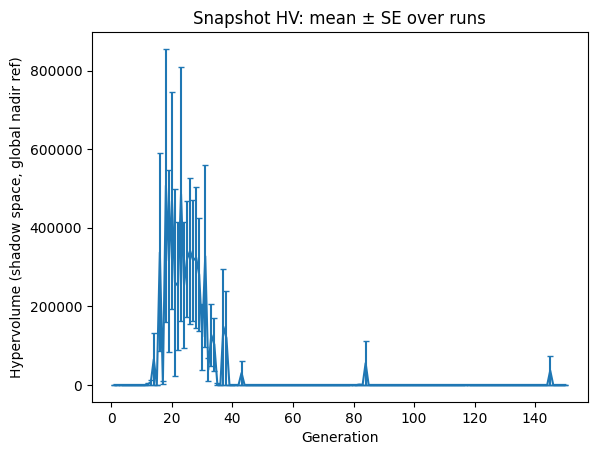

In [282]:
g = hv_summary["generation"].to_numpy()
m = hv_summary["hv_mean"].to_numpy()
se = hv_summary["hv_stderr"].to_numpy()

plt.figure()
plt.plot(g, m)
plt.errorbar(g, m, yerr=se, fmt="none", capsize=2)  # stderr bars
plt.xlabel("Generation")
plt.ylabel("Hypervolume (shadow space, global nadir ref)")
plt.title("Snapshot HV: mean ± SE over runs")
plt.show()